
# Assignment 1

* Load the IMDb dataset and preprocess it correctly into [variable size batches](https://dlvu.github.io/sequences/#slide-023).
* Build a model consisting of:
  1. An embedding layer
  2. A global pool (max, avg or sum)
  3. A linear projection down to 2 classes.
* Train it on the IMDb data and measure your validation set accuracy. It should come to about 85%.
* Play around with the hyperparameters (embedding dimension, pooling operation, initialization) to see if anything affects the accuracy. As discussed, we hypothesize that most changes will not have an effect for this model.

Attached is **assignment 3B** from our Deep Learning course. **Questions 1 and 2** are basically the goals for next week (you can ignore the rest of the assignment). It tells you how to load the data and gives some tips on setting up the model.

## 0. Download the data_rnn script

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=4c2bdac4952eec3b700410c98b8ce6b383f9dfe32dd59bc012b3c3b54ecba79c
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [2]:
from google.colab import drive
from collections import defaultdict
import os
import sys
import textwrap
from pathlib import Path
from typing import List, Dict, Union, Tuple, Generator
import torch
import pandas as pd
import numpy as np
import regex as re
import torch.nn as nn
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from timeit import default_timer as Timer

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
os.chdir("/content/drive/MyDrive/Thesis/scripts")
os.getcwd()

'/content/drive/MyDrive/Thesis/scripts'

In [5]:
file = 'data_rnn.py'

In [6]:
if not os.path.exists(file):
    !wget -O data_rnn.py "https://gist.githubusercontent.com/pbloem/2c3af77626d6c80f62487c35a28e3e8c/raw/5730d8f548a55a98b4415a457c5d827b33cd64d3/data_rnn.py"
else:
    print("File already exists.")

File already exists.


## 1. Load and inspect the data

Notes on `load_imdb()`:
* If final is **true**, the function returns the **canonical test/train split** with 25 000 reviews in each.
* If final is **false**, a **validation split** is returned with 20 000 training instances and 5 000
validation instances.

In [7]:
sys.path.append('/content/drive/MyDrive/Thesis/scripts')
from data_rnn import load_imdb

In [8]:
help(load_imdb)

Help on function load_imdb in module data_rnn:

load_imdb(final=False, val=5000, seed=0, voc=None, char=False)



In [9]:
(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = load_imdb(final=False)

### 1.1 Training set

In [10]:
# x_train --> A python list of lists of integers. Each integer represents a word. Sorted from short to long.
# y_train --> The corresponding class labels: 0 for positive, 1 for negative.
len(x_train), len(y_train)

(20000, 20000)

In [11]:
x_train[0], y_train[0]

([14, 19, 9, 379, 22, 11, 50, 52, 53, 290], 1)

In [12]:
class_name = ['positive', 'negative']

for i in range(5):
  print(" ".join([i2w[word] for word in x_train[i]]),
        f'\nLabel: {class_name[y_train[i]]}',
        "\n--------------------------------\n")

this movie is terrible but it has some good effects 
Label: negative 
--------------------------------

i wouldn t rent this one even on dollar rental night 
Label: negative 
--------------------------------

ming the merciless does a little bardwork and a movie most foul 
Label: negative 
--------------------------------

long boring blasphemous never have i been so glad to see ending credits roll 
Label: negative 
--------------------------------

no comment stupid movie acting average or worse screenplay no sense at all skip it 
Label: negative 
--------------------------------



In [13]:
len(x_train[0]), len(x_train[1257]), len(x_train[-1])

(10, 74, 2514)

### 1.2 Validation set

In [14]:
# x_val --> Test/validation data. Laid out the same as x_train.
# y_val --> Test/validation labels
len(x_val), len(y_val)

(5000, 5000)

In [15]:
for i in range(5):
  print(textwrap.fill(" ".join([i2w[word] for word in x_val[i]]), 200),
        f'\nLabel: {class_name[y_val[i]]}',
        "\n--------------------------------\n")

# for i in range(4999,5000):
#   print(textwrap.fill(" ".join([i2w[word] for word in x_val[i]]), 200),
#         f'\nLabel: {class_name[y_val[i]]}',
#         "\n--------------------------------\n")



adrian pasdar is excellent is this film he makes a fascinating woman 
Label: positive 
--------------------------------

you d better choose paul verhoeven s even if you have watched it 
Label: negative 
--------------------------------

comment this movie is impossible is terrible very improbable bad interpretation e direction not look 
Label: negative 
--------------------------------

smallville episode justice is the best episode of smallville it s my favorite episode of smallville 
Label: positive 
--------------------------------

excellent episode movie ala pulp fiction days suicides it doesnt get more depressing than this movie rating music rating 
Label: positive 
--------------------------------



### 1.3 String mappings

In [16]:
# i2w --> A list of strings mapping the integers in the sequences to their original words.
# i2w[141] returns the string containing word 141.

# w2i --> A dictionary mapping the words to their indices. w2i['film'] returns the indexfor the word "film".
len(i2w), len(w2i)

(99430, 99430)

In [17]:
i2w[:10]

['.pad', '.start', '.end', '.unk', 'the', 'and', 'a', 'of', 'to', 'is']

In [18]:
i2w[-6:]

['haralambopoulos', 'athinodoros', 'prousalis', 'nikolaidis', 'imy', 'jayden']

In [19]:
numcls

2

## 2. Batching and padding the data
To train, you'll need to loop over x_train and y_train and slice out batches. Each batch will need to be padded to a fixed length and then converted to a torch tensor.


Implement this padding and conversion. Show the function in your report.

### 2.1 Analyze review length distribution

In [20]:
# Create a dictionary where each key has a standard value of 0
count_dict: Dict[int,int] = defaultdict(int)

# Counts the reviews with the same length in train_x and stores them in a dictionary
for review in x_train:
  count_dict[len(review)] += 1

data = [[length, count] for length, count in count_dict.items()]
df_counts = pd.DataFrame(data,
                         columns=['Review_length', 'Count']
                         )
df_counts.head(10)

,Review_length,Count
0,10,1
1,11,1
2,12,1
3,14,1
4,15,1
5,16,1
6,17,2
7,19,1
8,20,1
9,22,3


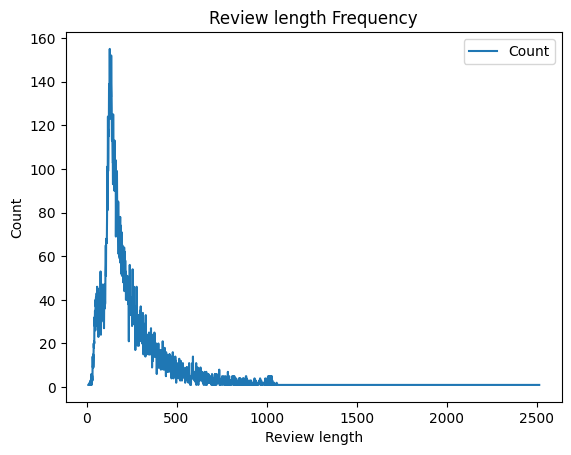

In [21]:
ax = df_counts.plot(kind="line", x="Review_length", y="Count")
ax.set_xlabel("Review length")
ax.set_ylabel("Count")
ax.set_title("Review length Frequency");

### 2.2 Batching and Padding functions

In [22]:
def create_batches(data: List[List[int]], labels: List[int]) -> List[List[List[int]]]:
  """
  Takes list of reviews and labels and turns them into batches of labels and reviews of uniform length.
  Params
    data: A list of reviews.
    labels: A list of labels
  Returns
    A list of batches containing reviews, each padded to ensure uniform length.
  """
  data, labels = data.copy(), labels.copy()
  data_and_labels = zip(data,labels)

  # Sorts the data from longest to shortest reviews and unzips data from labels
  data, labels = list(zip(*sorted(data_and_labels,
                             key=lambda x: len(x[0]),
                             reverse=True)
  ))

  data_batch: List[List[int]] = []
  label_batch: List[int] = []

  data_batches: List[List[List[int]]] = []
  label_batches: List[List[int]] = []

  curr_review_length: int = 0


  # Determines the size of the longest review
  max_tokens: int = max(len(review) for review in data)

  # loop over the list of reviews (x_train)
  for review_idx in range(len(data)):
    curr_review: List[int] = data[review_idx]
    curr_label: int = labels[review_idx]
    num_tokens: int = sum(len(review) for review in data_batch) # Calculate the number of tokens in the data_batch

    # If data_batch is empty add a review and set current review length
    if num_tokens == 0:
      data_batch.append(curr_review)
      label_batch.append(curr_label)
      curr_review_length = len(curr_review)

    # If the number of tokens in a data_batch exceed the limit or adding an extra token of the same size exceeds the limit:
    elif (num_tokens >= max_tokens) or (num_tokens + curr_review_length >= max_tokens):
      # Add the current data_batch to the list of data_batches
      data_batches.append(data_batch)
      label_batches.append(label_batch)
      # Create an empty data_batch for the next reviews
      data_batch = []
      label_batch = []
      # Append current review to new data_batch
      data_batch.append(curr_review)
      label_batch.append(curr_label)
      # Reset current review length
      curr_review_length = len(curr_review)

    else:
      padding = curr_review_length - len(curr_review) # Calculate padding needed for next token
      curr_review += padding * [0] # Add padding to next token
      data_batch.append(curr_review) # Add a review to the data_batch list
      label_batch.append(curr_label)

  # Ensures that the final data_batch is also added.
  if data_batch:
    data_batches.append(data_batch)
    label_batches.append(label_batch)

  return data_batches, label_batches

#################################################################################

def read_review(review: List[int])-> None:
  """
  Takes a list of integers as input and prints their string representation.
  Params:
    review: A list of integers.
  Returns:
    None
  """
  print(textwrap.fill(" ".join([i2w[word] for word in review]), 100),)

##################################################################################

def show_batches(data_batches, label_batches,
                 batch_num: int = 0,
                 print_reviews: bool = True) -> None:
  """
  Filler.
  """
  class_name = ['Positive', 'Negative']

  num_data_batches  = len(data_batches)
  num_label_batches = len(label_batches)

  data_batch  = data_batches[batch_num]
  label_batch = label_batches[batch_num]

  num_tokens = sum(len(review) for review in data_batch)

  review_length = len(data_batch[0])

  # check if reviews are all the same size
  same_size = max(len(review) for review in data_batch) == min(len(review) for review in data_batch)


  print(f"Number of data batches: {num_data_batches} | Number of label batches {num_label_batches}",
        f"\nBatch number: {batch_num}"
        "\n____________________________________________\n")
  print(f"Number of tokens in batch: {num_tokens}")
  print(f"Review length: {review_length}",
        f"\nReviews are the same size: {same_size}")
  print(f"Data batch size: {len(data_batch)} | Label batch size: {len(label_batch)}",
        "\n_____________________________________________\n")

  if print_reviews:
    for review, label in zip(data_batch, label_batch):
      read_review(review)
      print(f'\nLabel: {class_name[label]}', "\n------------------------------------")



In [23]:
x_batches, y_batches = create_batches(x_train, y_train)
len(x_batches), len(y_batches)

(2085, 2085)

In [24]:
show_batches(x_batches, y_batches, 2000, False)

Number of data batches: 2085 | Number of label batches 2085 
Batch number: 2000
____________________________________________

Number of tokens in batch: 2420
Review length: 110 
Reviews are the same size: True
Data batch size: 22 | Label batch size: 22 
_____________________________________________



### 2.3 Convert data to tensors

In [25]:
# Sets up device agnostic code --> Uses GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [26]:
def data_to_tensor_batch(data: List[list[int]],
                         labels: List[int],
                         device: str=device) -> Tuple[Generator[torch.Tensor, None, None], Generator[torch.Tensor, None, None]] :
  """
  Filler.
  """
  x_batches, y_batches = create_batches(data, labels)
  x_batched_tensors = (torch.tensor(batch, dtype=torch.long, device=device) for batch in x_batches)
  y_batched_tensors = (torch.tensor(batch, dtype=torch.long, device=device) for batch in y_batches)

  return x_batched_tensors, y_batched_tensors

In [27]:
# Create batched tensors and check shape
x_train_tensors, y_train_tensors = data_to_tensor_batch(x_train, y_train)
next(x_train_tensors).shape, next(y_train_tensors).shape, next(x_train_tensors).device

(torch.Size([1, 2514]), torch.Size([1]), device(type='cpu'))

## 3. Build our first model
We'll start with the simplest sequence-to-sequence model discussed in the lectures: a Linear
layer applied to each token in the sequence separately.

Notes:
* Make sure to read the documentation for the layers used carefully
* Use **embedding size 300**.
* The **embedding layer needs to know how many tokens there are** (since that is how
many embedding vectors it needs to create). How can you find this from the return
values of the load_imdb function?

* The model is not memory-intensive, so you can easily go to large batch sizes to
speed up training. Note, however, that the amount of padding also increases with the
batch size. Can you explain why?
* It's most common **not to make softmax part of the model**, but to apply it as part of the
loss function, since this can be done in a more numerically stable way. The function **torch.nn.functional.cross_entropy** can be used to calculate the loss here.
Make sure to read the documentation carefully so that you know what it expects.
  * Note that when computing accuracy, **we only need the class with the highest score**, so we can just compute the **argmax** over the **linear outputs**.
  * A common mistake is to mix up cross entropy, which applies the softmax, and
  nll_loss which expects the model to apply a (log) softmax. You end up either
  not applying a softmax or applying it twice.

### 3.1 Classification, baseline model

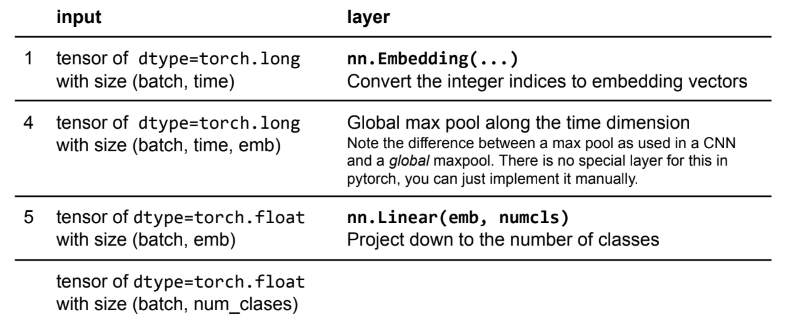






In [28]:
# The size of the vocabulary
len(i2w)

99430

In [29]:
# Creates an embedding layer
embedding = nn.Embedding(num_embeddings=len(i2w), embedding_dim=300)
embedding.to(device)

Embedding(99430, 300)

In [30]:
test_batch = next(x_train_tensors)
test_batch.shape, test_batch

(torch.Size([1, 1773]), tensor([[ 37, 151,  24,  ...,   6, 793,  23]]))

In [31]:
emb_vectors = embedding(test_batch)
emb_vectors.shape, emb_vectors

(torch.Size([1, 1773, 300]),
 tensor([[[ 0.4212, -0.6980, -0.6004,  ..., -0.4115, -1.3711, -0.1192],
          [-0.1263,  2.2018, -0.2210,  ...,  0.0919, -0.5125,  0.2930],
          [ 0.4556,  0.3534, -0.1114,  ..., -0.1811,  0.2021,  0.3139],
          ...,
          [ 1.1528, -0.2565,  0.2186,  ..., -0.8736,  2.7580,  1.1594],
          [-0.4132, -3.6870, -0.0132,  ...,  0.4143,  0.2455, -0.7374],
          [-1.0376, -0.8973, -0.4294,  ..., -0.5022,  0.2004, -0.1473]]],
        grad_fn=<EmbeddingBackward0>))

In [32]:
# # Torch max function
# help(torch.max)

In [33]:
random_tensor = torch.randn(size=(4,4,300),
                            device=device)
random_tensor

tensor([[[-1.0554, -0.1171, -0.7720,  ..., -0.8253,  0.3519, -0.5939],
         [ 1.2405, -1.4763,  0.5902,  ...,  0.4752,  0.1836, -1.1330],
         [ 2.0183, -0.8337,  0.1067,  ..., -0.7966,  0.4638, -0.8084],
         [ 0.1355,  0.5029, -1.4812,  ...,  1.1691, -1.4967,  0.4296]],

        [[ 0.6598, -0.2094, -1.1355,  ..., -3.6202,  2.1880, -0.2500],
         [-0.1596,  0.6043, -1.7346,  ...,  0.9644,  0.4658, -0.0542],
         [-0.6798, -0.6300, -1.3284,  ..., -0.9632,  0.5579, -0.5374],
         [-1.3896,  0.1059,  0.3201,  ...,  0.6765,  1.2425, -1.1930]],

        [[-0.1910, -1.0559, -1.7718,  ...,  0.3196, -0.0511,  1.5278],
         [-1.0624, -0.0073, -0.4366,  ..., -0.9589, -1.5621,  1.5314],
         [-0.7161,  1.6959, -0.8948,  ..., -0.2763, -0.2746, -0.0933],
         [ 1.5204, -1.7914,  2.0062,  ...,  0.2593,  0.3746,  1.1963]],

        [[-0.9702,  0.5034,  1.1141,  ..., -0.8506, -0.8623,  1.0892],
         [ 0.3096,  0.3875,  1.4814,  ...,  0.2136,  0.3514, -0.5524],


In [34]:
# Pool the max of the second dimension (dim=1)
x = random_tensor.max(dim=1).values

In [35]:
torch.manual_seed(22)
random_tensor = torch.randn(size=(4,4,5), # batch_size: 4, sequence_size = 10, embedding_size = 10
                            device=device)
torch.max(random_tensor, dim=0)[0], random_tensor

(tensor([[ 1.0136,  0.7359,  0.6198,  1.1686,  1.0492],
         [ 1.7440,  2.0421,  1.3273,  2.7949,  2.0945],
         [ 1.5132,  0.0352,  1.4632,  0.8134,  0.2734],
         [ 0.5904,  1.1319,  0.8002,  1.0861, -0.0626]]),
 tensor([[[ 0.3920,  0.0734, -0.0045, -0.0535, -0.0589],
          [ 0.6002,  2.0421,  1.3273, -0.8703, -1.5555],
          [-0.8620, -0.1290,  1.4632,  0.2698, -1.3583],
          [-0.7568, -0.4102,  0.2939, -0.0538, -0.9547]],
 
         [[-1.3138,  0.4306, -1.3356,  1.1686,  0.9662],
          [-1.7636, -1.9802, -0.0056,  0.8050,  0.7928],
          [-0.6498,  0.0352, -1.1281,  0.8134,  0.2734],
          [-0.3833,  1.1319, -0.1240, -0.6294, -0.5749]],
 
         [[-0.8881,  0.7359,  0.6198,  0.3908,  1.0492],
          [ 0.3543,  0.0289, -1.0003, -0.6858,  2.0945],
          [ 0.7393, -0.0455, -1.7682, -0.1843, -1.3310],
          [ 0.5904,  0.8605,  0.8002,  1.0861, -0.0626]],
 
         [[ 1.0136, -0.7909, -0.5482,  1.1483,  0.9765],
          [ 1.7440,  0.7

In [36]:
torch.cuda.manual_seed(22)
linear_layer = nn.Linear(in_features=300,
                         out_features=numcls,
                         device=device)
linear_layer(x).argmax(dim=1)

tensor([0, 0, 0, 0])

In [37]:
class GlobalMaxPooling(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    """Extracts the max across the time (sequence) dimension and returns the values of the embedded vector.
    """
    return torch.max(x, dim=1)[0]

#########################################################


class SentimentClassificationModelV0(nn.Module):

  def __init__(self, vocab_size, emb_size, output_shape):
    """
    Params
      vocab_size: The size of the vocabulary.
      emb_size: The size of the embedding vector
      output_shape:
    """
    super().__init__()
    self.sequence = nn.Sequential(nn.Embedding(num_embeddings=vocab_size, # Convert the integer indices to embedding vectors
                                               embedding_dim=emb_size,
                                               padding_idx=0),
                                  GlobalMaxPooling(), # Global max pooling along sequence dimension
                                  # nn.ReLU(),
                                  nn.Linear(in_features=emb_size, # Project down to the number of classes
                                  out_features=output_shape)
                                  )


  def forward(self, x):
    return self.sequence(x)

In [38]:
model_0 = SentimentClassificationModelV0(vocab_size = len(i2w),
                               emb_size = 300,
                               output_shape = numcls).to(device)

In [39]:
x_train_batches, y_train_batches = data_to_tensor_batch(x_train, y_train)
example_data, example_label = next(x_train_batches), next(y_train_batches)

In [40]:
torch.manual_seed(42) # Call a manual seed

model_0.eval() # Set model to evaluation mode
with torch.inference_mode():
  pred = model_0(example_data)

torch.softmax(pred, dim=1), pred.argmax(1), example_label

(tensor([[0.0580, 0.9420]]), tensor([1]), tensor([0]))

In [41]:
def accuracy_fn(y_pred, y_true):
    """Calculates accuracy between truth labels and predictions.

    Params:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [42]:
# Input values for CrossEntropyLoss(): loss(input, target)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.01)

In [43]:
# Load full training set
x_train_gen, y_train_gen = data_to_tensor_batch(x_train, y_train)
Xy_train_set = list(zip(x_train_gen, y_train_gen))

# Train Validation split
VAL_SIZE = 0.2
SEED = 22

Xy_train_set, Xy_val_set = train_test_split(Xy_train_set,
                                            test_size=VAL_SIZE,
                                            random_state=SEED)
# Print Results
print(f"Batch size Training: {len(Xy_train_set)} | Batch size Validation: {len(Xy_val_set)}.")
print(f"Reviews in Training: {sum(len(x[0]) for x in Xy_train_set)} \
| Reviews in Validation: {sum(len(x[0]) for x in Xy_val_set)}." )


Batch size Training: 1668 | Batch size Validation: 417.
Reviews in Training: 15960 | Reviews in Validation: 4040.


In [44]:
print(f"training on {device}.")

training on cpu.


In [45]:
def train_step(model,
               train_data,
               loss_function,
               accuracy_function,
               optimizer,
               device):
  """
  """

  # Set model to device and evaluation mode

  model.train()

  train_loss, train_acc = 0, 0

  for X, y in train_data:
    X, y = X.to(device), y.to(device)

    # 1. Forward Pass
    y_logits = model(X) # Output is raw logits
    y_preds = y_logits.argmax(dim=1) # Turns logits into predictions

    # 2.1 Calculate Loss and Accuracy
    loss = loss_fn(y_logits,
                  y)
    acc = accuracy_function(y_pred=y_preds,
                            y_true=y)

    # 2.2 Accumulate Loss and Accuracy
    train_loss += loss.item()
    train_acc += acc

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Step
    optimizer.step()

  train_loss /= len(train_data)
  train_acc /= len(train_data)

  print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train accuracy {train_acc:.2f}%")


############################################################################


def test_step(model,
              test_data,
              loss_function,
              accuracy_function,
              device):
  '''
  '''
  # Set model to device and evaluation mode

  model.eval()



  with torch.inference_mode():
    test_loss, test_acc = 0, 0
    for X, y in test_data:
      X, y =  X.to(device), y.to(device)

      # 1. Forward Pass
      y_logits = model(X) # Output is raw logits
      y_preds = y_logits.argmax(dim=1) # Turns logits into predictions

      # 2.1 Calculate Loss and Accuracy
      loss = loss_fn(y_logits,
                    y)
      acc = accuracy_function(y_pred=y_preds,
                        y_true=y)
      # 2.2 Accumulate Loss and Accuracy
      test_loss += loss.item()
      test_acc += acc

    test_loss /= len(test_data)
    test_acc /= len(test_data)
    print(f"Epoch: {epoch} | Test loss: {test_loss:.4f} | Test accuracy {test_acc:.2f}%")


###################################################################################

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [46]:
torch.cuda.manual_seed(22)
epochs = 1
train_time_start_on_gpu = Timer()


for epoch in tqdm(range(epochs)):

  # Train step
  train_step(model=model_0,
             train_data=Xy_train_set,
             loss_function=loss_fn,
             accuracy_function=accuracy_fn,
             optimizer=optimizer,
             device=device)
  # Test step
  test_step(model=model_0,
            test_data=Xy_val_set,
            loss_function=loss_fn,
            accuracy_function=accuracy_fn,
            device=device)

  train_time_end_on_gpu = Timer()
  total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                              end=train_time_end_on_gpu,
                                              device=device)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.6600 | Train accuracy 68.94%
Epoch: 0 | Test loss: 0.4293 | Test accuracy 86.82%
Train time on cpu: 1038.510 seconds


In [47]:
def train_early_stopping(model,
                         train_data,
                         loss_function,
                         accuracy_function,
                         optimizer,
                         device,
                         val_data=None,
                         val_step=32,
                         threshold=2):
    """
    Primitive version of training with early stopping.
    """
    patience = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.to(device)
    model.train()

    train_loss, train_acc = 0.0, 0.0

    for batch_count, (X, y) in enumerate(train_data, start=1):
        X, y = X.to(device), y.to(device)

        # Forward
        y_logits = model(X)
        y_preds = y_logits.argmax(dim=1)

        # Loss and accuracy
        loss = loss_function(y_logits, y)
        acc = accuracy_function(y_preds, y)

        # Accumulate
        train_loss += loss.item()
        train_acc += acc

        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validate every `val_step` batches
        if val_data is not None and batch_count % val_step == 0:
            model.eval()
            val_loss, val_acc = 0.0, 0.0

            with torch.inference_mode():
                for X_val, y_val in val_data:
                    X_val, y_val = X_val.to(device), y_val.to(device)

                    y_logits_val = model(X_val)
                    y_preds_val = y_logits_val.argmax(dim=1)

                    loss_val = loss_function(y_logits_val, y_val)
                    acc_val = accuracy_function(y_preds_val, y_val)

                    val_loss += loss_val.item()
                    val_acc += acc_val

            val_loss /= len(val_data)
            val_acc /= len(val_data)

            train_loss_avg = train_loss / batch_count
            train_acc_avg = train_acc / batch_count

            train_losses.append(train_loss_avg)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc_avg)
            val_accuracies.append(val_acc)

            print(f"[Batch {batch_count}] Train loss: {train_loss_avg:.4f}, Val loss: {val_loss:.4f}")

            # Early stopping check
            if len(val_losses) > 1 and val_losses[-1] > val_losses[-2]:
                patience += 1
            else:
                patience = 0

            if patience > threshold:
                print("Early stopping triggered.")
                break

            model.train()  # Back to training mode

    return train_losses, val_losses, train_accuracies, val_accuracies


In [48]:
train_early_stopping(model=model_0,
                    train_data=Xy_train_set,
                    loss_function=loss_fn,
                    accuracy_function=accuracy_fn,
                    optimizer=optimizer,
                    device=device,
                    val_data=Xy_val_set,
                    val_step=32,
                    threshold=5)
print('end')

[Batch 32] Train loss: 0.3899, Val loss: 0.7473
[Batch 64] Train loss: 0.4233, Val loss: 0.4432
[Batch 96] Train loss: 0.4673, Val loss: 6.4064
[Batch 128] Train loss: 0.8596, Val loss: 0.5183
[Batch 160] Train loss: 1.2807, Val loss: 6.9263
[Batch 192] Train loss: 1.2904, Val loss: 0.7459
[Batch 224] Train loss: 1.1808, Val loss: 0.4966
[Batch 256] Train loss: 1.0821, Val loss: 0.8234
[Batch 288] Train loss: 1.0122, Val loss: 1.9302
[Batch 320] Train loss: 0.9946, Val loss: 0.6704
[Batch 352] Train loss: 0.9852, Val loss: 1.3151
[Batch 384] Train loss: 0.9678, Val loss: 0.7411
[Batch 416] Train loss: 0.9193, Val loss: 3.8757
[Batch 448] Train loss: 0.9088, Val loss: 1.3652
[Batch 480] Train loss: 0.8850, Val loss: 0.5378
[Batch 512] Train loss: 0.8539, Val loss: 0.6769
[Batch 544] Train loss: 0.8289, Val loss: 0.6851
[Batch 576] Train loss: 0.8050, Val loss: 1.3061
[Batch 608] Train loss: 0.7719, Val loss: 0.5123
[Batch 640] Train loss: 0.7703, Val loss: 1.1569
[Batch 672] Train loss:

### 3.1 Implementing Mean Pooling

In [49]:
class GlobalMeanPooling(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    """Extracts the mean across the time (sequence) dimension and returns the values of the embedded vector.
    """
    return torch.mean(x, dim=1)

#########################################################


class SentimentClassificationModelV1(nn.Module):

  def __init__(self, vocab_size, emb_size, output_shape):
    """
    Params
      vocab_size: The size of the vocabulary.
      emb_size: The size of the embedding vector
      output_shape:
    """
    super().__init__()
    self.sequence = nn.Sequential(nn.Embedding(num_embeddings=vocab_size, # Convert the integer indices to embedding vectors
                                               embedding_dim=emb_size,
                                               padding_idx=0),
                                  GlobalMeanPooling(), # Global max pooling along sequence dimension
                                  # nn.ReLU(),
                                  nn.Linear(in_features=emb_size, # Project down to the number of classes
                                  out_features=output_shape)
                                  )


  def forward(self, x):
    return self.sequence(x)

In [50]:
model_1 = SentimentClassificationModelV1(vocab_size=len(i2w),
                                         emb_size=300,
                                         output_shape=numcls)

In [51]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr = 0.01)

In [52]:
torch.cuda.manual_seed(22)
epochs = 3
train_time_start_on_gpu = Timer()


for epoch in tqdm(range(epochs)):

  # Training
  train_step(model=model_1,
             train_data=Xy_train_set,
             loss_function=loss_fn,
             accuracy_function=accuracy_fn,
             optimizer=optimizer,
             device=device)
  #  Validation
  test_step(model=model_1,
            test_data=Xy_val_set,
            loss_function=loss_fn,
            accuracy_function=accuracy_fn,
            device=device)

  train_time_end_on_gpu = Timer()
  total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                              end=train_time_end_on_gpu,
                                              device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.3528 | Train accuracy 84.33%
Epoch: 0 | Test loss: 0.3043 | Test accuracy 87.35%
Train time on cpu: 932.502 seconds
Epoch: 1 | Train Loss: 0.0933 | Train accuracy 96.95%
Epoch: 1 | Test loss: 0.5101 | Test accuracy 84.51%
Train time on cpu: 1918.351 seconds


KeyboardInterrupt: 

In [ ]:
random_tensor = torch.randn(3, 300,20)
random_tensor.mean(dim=1), random_tensor

In [ ]:
model_1_2 = SentimentClassificationModelV1(vocab_size=len(i2w),
                                         emb_size=300,
                                         output_shape=numcls)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1_2.parameters(),
                             lr = 0.01)

In [ ]:
train_early_stopping(model=model_1_2,
                     train_data=Xy_train_set,
                     loss_function=loss_fn,
                     accuracy_function=accuracy_fn,
                     optimizer=optimizer,
                     device=device,
                     val_data=Xy_val_set,
                     val_step=32,
                     threshold=3)
print("end")

In [ ]:
print(f"Model: 0 ---> Global Max Pooling trained for 3 epochs")
test_step(model_0,
          Xy_val_set,
          loss_fn,
          accuracy_fn,
          device)
print(f"\nModel: 1 ---> Global Max Pooling trained for 1 epoch")
test_step(model_1,
          Xy_val_set,
          loss_fn,
          accuracy_fn,
          device)
print(f"\nModel: 1.2 ---> Global Mean Pooling trained for 1 epoch")
test_step(model_1_2,
          Xy_val_set,
          loss_fn,
          accuracy_fn,
          device)

